## Libraries

In [1]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
import time
from numpy import mean
from numpy import std
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Model 0: Calibration with Earth-Like Inputs

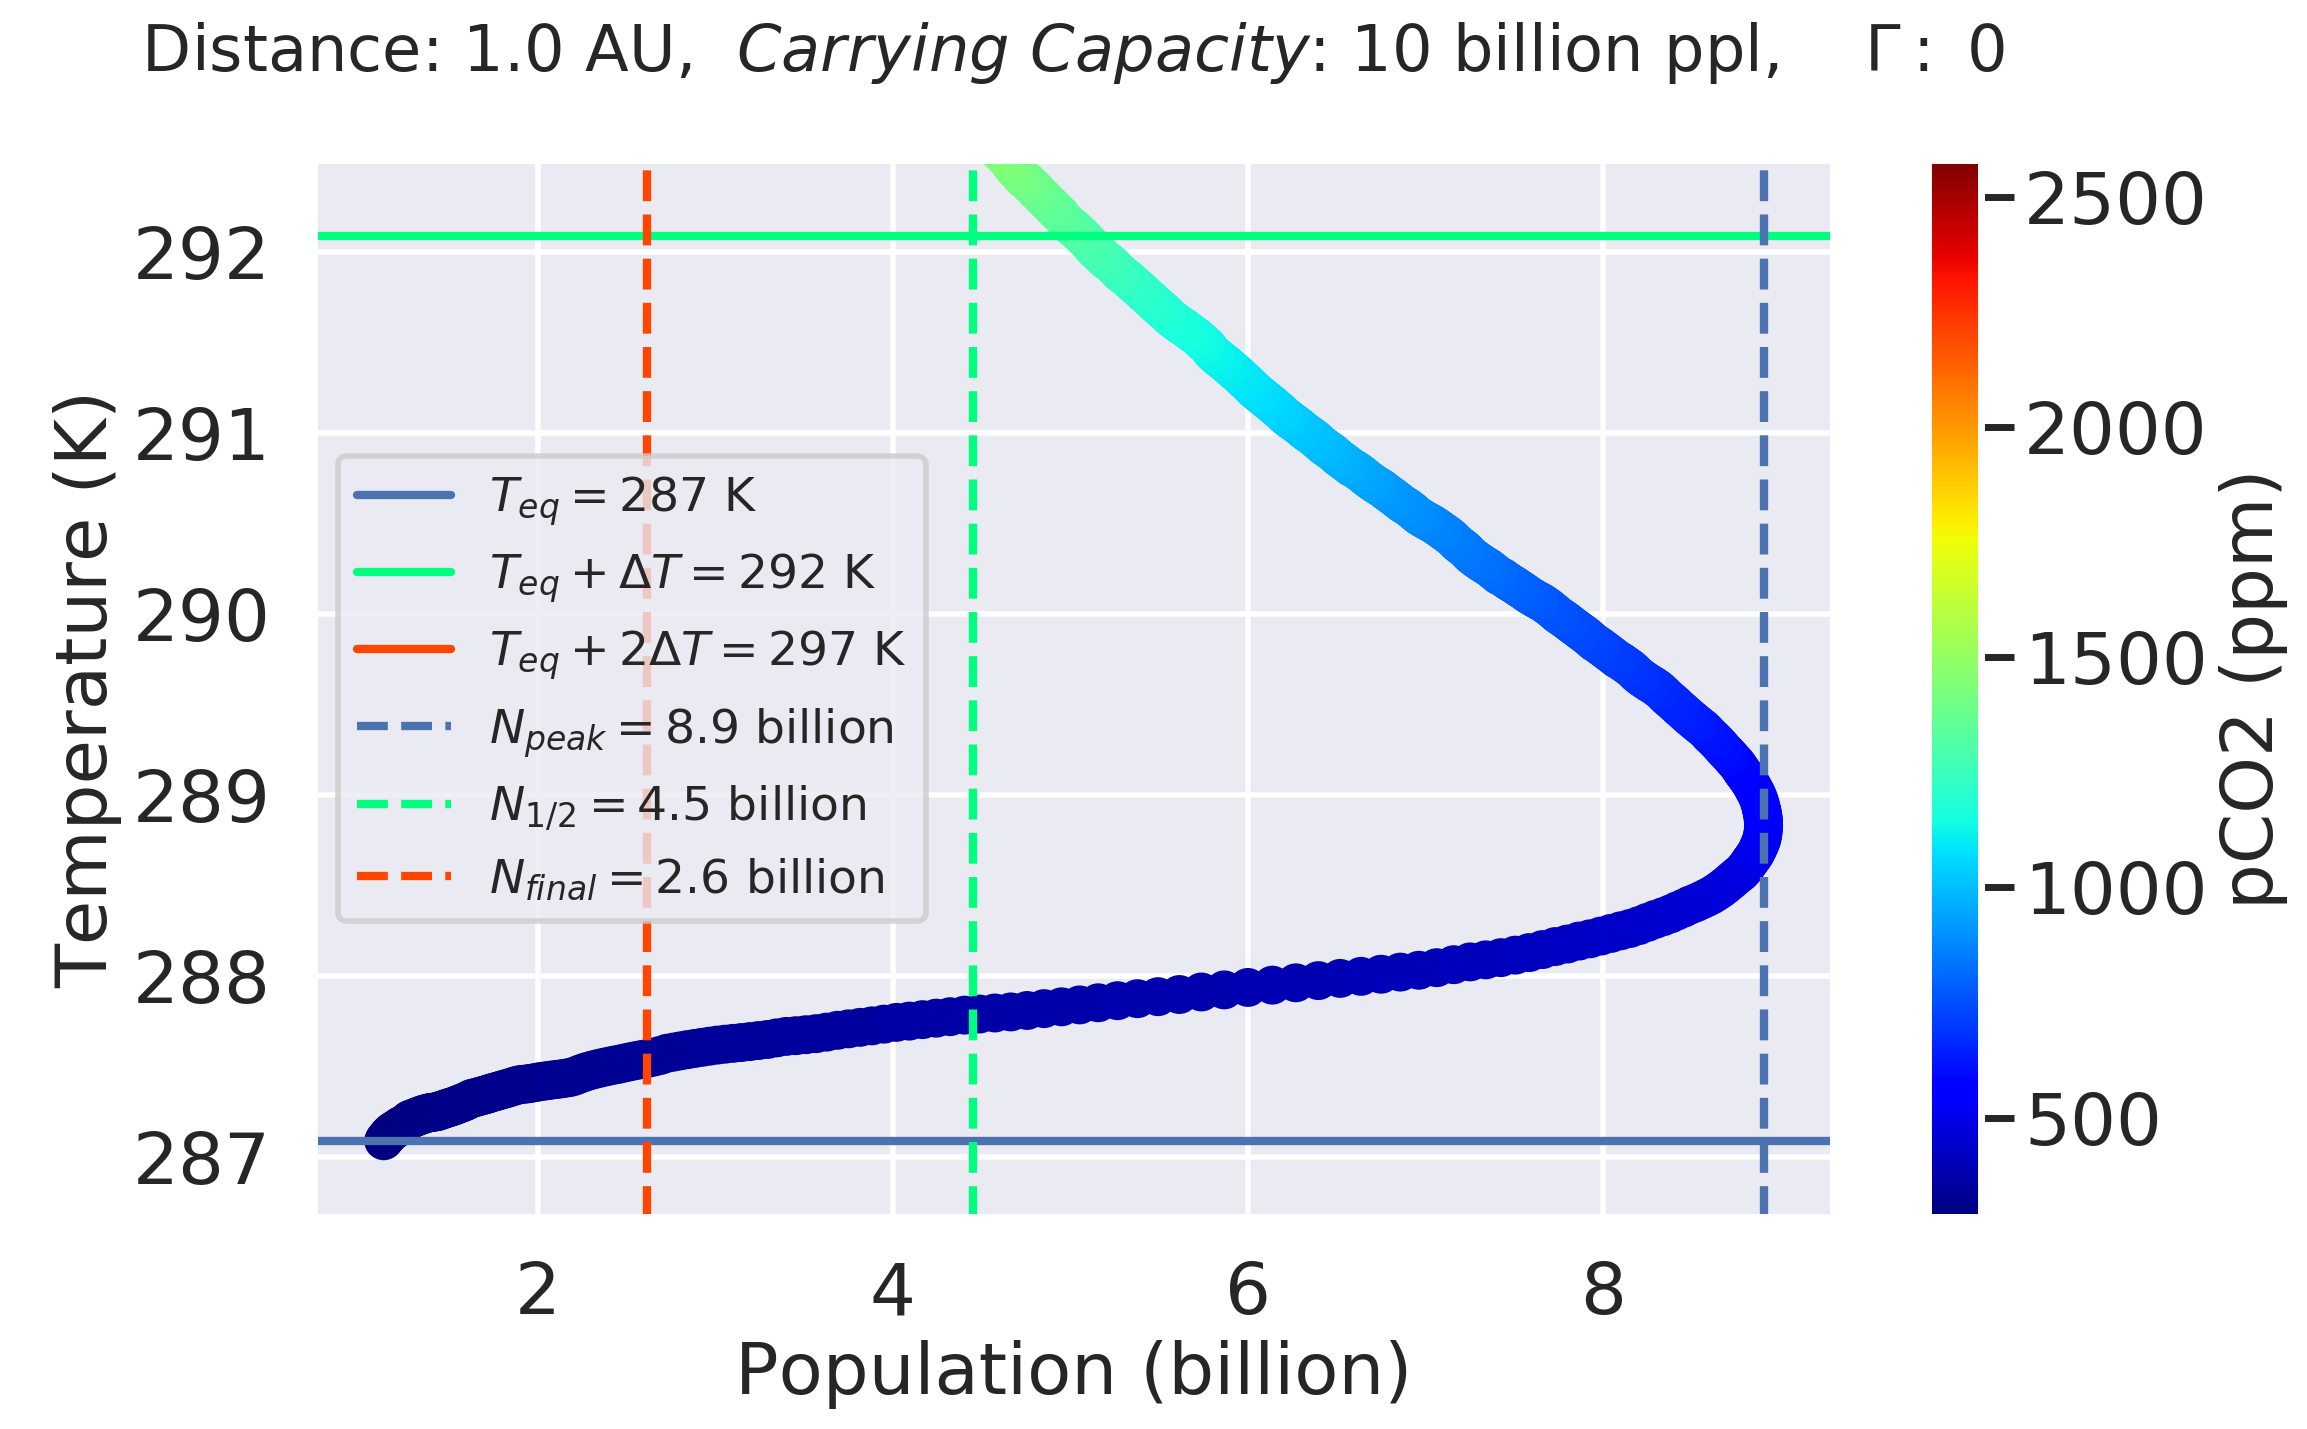

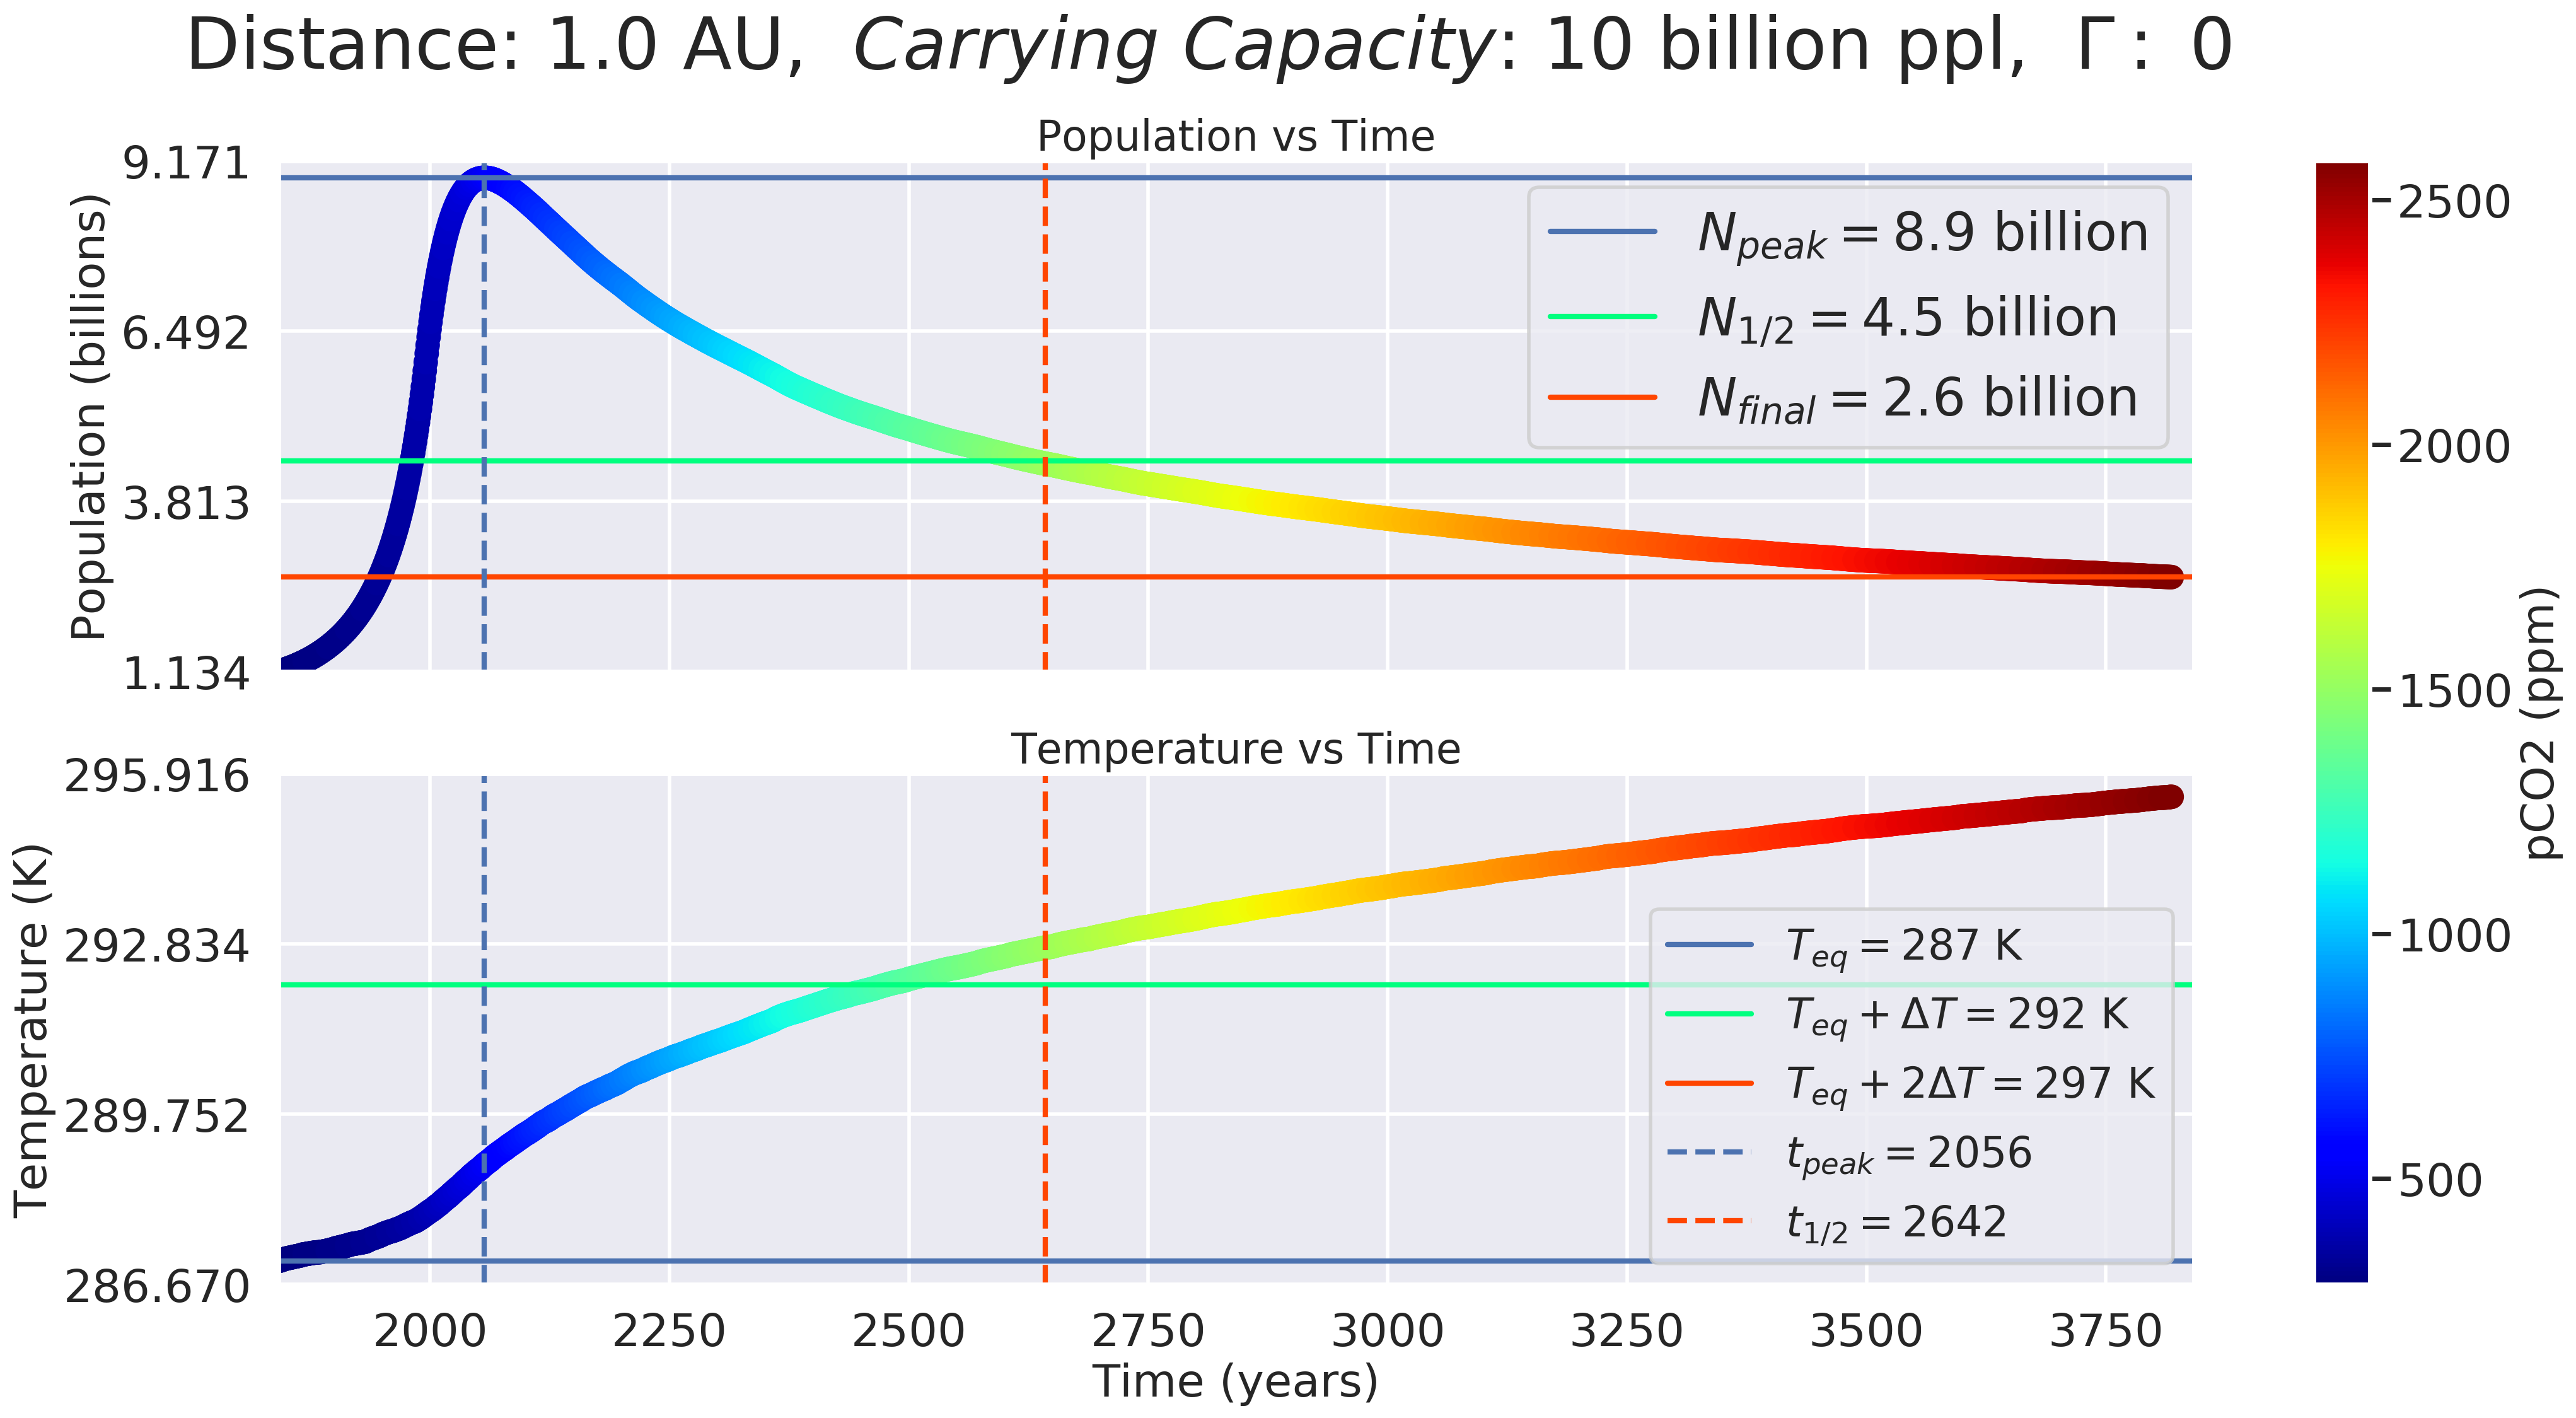

In [15]:
nameList = makeDefNamelist() #make namelist
#-------------------------------------Boolean Inputs--------------------------------------------------
plot=True;#make the fancy plots?
save=False;#save the file
coupled=True;
analyze = True #whether or not to analyze the population parts of model
lverbose=False #controls terminal output, used for debugging
showInputs = False #prints the namelist before running the program
#-------------------------------------Other Important Inputs-------------------------------------------------
runTime=2000                          #Change runtime           (years)
newA = 1                              #Change distance           (AU)
pco20 = 284                           #Change Initial pCO2      (ppm)
nMax = 10;                            #Change Carrying Capacity (billion)
rBirth0 = .04;                       #Initial Birth Rate
rDeath0 = .036;                       #Initial Death Rate
dT      = 5;                           #Kelvin
dP      = 200;                         #higher values decrease growth rates
rco2    = 2.75*10**-4;
#----------------------------------Set NameList Values to Specified Inputs---------------------
maxPopList = [nMax*1000]
distList = [1]
nameList['ebm']['rBirth0']=rBirth0;   #Initial Birth Rate
nameList['ebm']['rDeath0']=rDeath0;   #Initial Death Rate
nameList['ebm']['Nmax']=nMax*1000;    #Maximum Population
nameList['ebm']['dtemp']=dT           #Fragility of Civilization
nameList['ebm']['dpco2']=dP*10**-6           #Technological Efficiency
nameList['ebm']['pco20']=pco20*10**-6  #Convert initial pCO2 to Bars
nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
nameList['ebm']['lverbose'] = lverbose
nameList['ebm']['rco2'] = rco2
#------------------------------------Run the Model----------------------------------------------------
dfModel,dfData,eq, eqTemp, eqTime = runModel(nameList, coupled, runTime, plot, save, analyze,"driver.exe",maxPopList,distList,showInputs)
finalTemp = dfModel['temp'][dfModel.index[-1]] #find final temperature
#------------------------------------Plot the Results----------------------------------------------
dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
#compareModelOutput(dfModel,dfTemp,dfPopCo2,eqTime)#compare the models output to true data
call("echo End of Python Notebook Reached", shell=True);

## Model A: Temperature Habitable Zone

In [3]:
# nameList = makeDefNamelist() #make namelist
# #-------------------------------------Boolean Inputs--------------------------------------------------
# plot=False;#make the fancy plots?
# save=False;#save the file
# life=False;
# coupled=False
# analyze = False #whether or not to analyze the population parts of model
# lverbose=False #controls terminal output, used for debugging
# #-------------------------------------Constant Inputs-------------------------------------------------
# driverName = "driver.exe" 
# newA=1                                #Change distance  (AU)
# runTime=100                             #Change runtime   (years)
# nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
# nameList['ebm']['rBirth0']=0.026;     #Initial Birth Rate
# nameList['ebm']['rDeath0']=0.015;     #Initial Death Rate
# nameList['ebm']['Nmax']=10000;        #Maximum Population
# nameList['ebm']['dtemp']=4#Fragility of Civilization
# # #------------------------------------Run the Model----------------------------------------------------
# maxPopList = [13000] #test list
# distList= [1.00] #test ;ost
# # maxPopList = [10000,40000,70000,100000] #specify all maxpops to use
# # distList= [0.94,0.97,1.00,1.03,1.06] #specify all distances to use
# iniTemp = 0
# prevTemp = 0
# eqTemp = 0
# outCount=0
# dictData = {}
# pco2Room = 0 #how much pco2 to have temp be room temp
# nameList['ebm']['lverbose'] = lverbose
# tempChange = 0
# # for i in np.linspace(.94,1.06,7):
# for i in [1]:
#     dP = 50
#     pco20 = 100
#     inCount = 0
#     pco2List = []
#     tempList = []
#     nameList['ebm']['relsolcon'] = i**-2 #set the distance
#     while(True): #increment pco2s until dT >= 5
#         nameList['ebm']['pco20']=pco20/10**6
#         prevTemp = eqTemp
#         dfModel,dfData,eq, eqTemp = runModel(nameList, coupled, runTime, plot, save, analyze, driverName,maxPopList,distList)
#         if(eq):#if equilibrium was reached
#             finalTemp = dfModel['temp'][dfModel.index[-1]] #find final temperature
#             pco2List.append(pco20)
#             tempList.append(eqTemp)
#             # calculate running averages/errors
# #             data_mean, data_std = mean(tempList), std(tempList)
# #             cut_off = data_std #find cutoff for outliers
# #             lower, upper = data_mean - cut_off, data_mean + cut_off
# #             print("Lower Bound: ",lower)
# #             print("Upper Bound: ",upper)
# #             print("eqTemp: ", eqTemp)
# #             if(inCount >= 3):    
# #                 if((eqTemp < lower) or (eqTemp > upper)):
# #                     print("removed outlier here")
# #                     pco20 += dP
# #                     continue #goto next iteration of loop
#             outCount += 2 #counter used to index arrays
#             inCount += 1 #counter used to specify initial temp
#             if(inCount == 1):# if first loop, set final temp to initial temp
#                 iniTemp = eqTemp
#             print(inCount,")","  dT: ", round((eqTemp-iniTemp),2),", pco20: ",pco20,", distance: ",i)
#             print(" Initial Temp: " ,round(iniTemp,2), "\n Final Temp: ",round(finalTemp,2),"\n Equilibrium Temp: ",round(eqTemp,2))
#             print("\n")
#             if((eqTemp - iniTemp) < 0): #if dT is ever negative, exit loop
#                 print("\n Error Encountered")
#                 break
#             if((eqTemp - iniTemp) >= 10): #exit condition
#                 plt.plot(pco2List,tempList)
#                 plt.xlabel("pCO2 (ppm)")
#                 plt.ylabel("Temp (K)")
#                 plt.title("Distance: " + str(i) + " AU")
#                 plt.show()
#                 break
#             else:
#                 pco20 += dP
#     dictData[outCount-1] = pco2List
#     dictData[outCount] = tempList
# #------------------------------------Plot the Results----------------------------------------------
# #growthRates(dfModel,True) #true to compare growth rates
# dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
# dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
# #compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data
# call("echo End of Python Notebook Reached", shell=True);

In [4]:
def KtoF(x):
    return (x-273.15)*(9/5)+32
def FtoK(x):
    return (x-32)*(5/9)+273.15

plt.plot(pco2List,tempList)
plt.xlabel("pCO2 (ppm)")
plt.ylabel(r'$T\ [K]$')
plt.title("Distance: " + str(i) + " AU")
ax = plt.gca()
axY2 = ax.secondary_yaxis("right", functions=(KtoF,FtoK))
axY2.set_ylabel(r'$T\ [^oF]$')
plt.show()

NameError: name 'pco2List' is not defined

In [ ]:
slopes = []
distances = []
dictDistances = {}
for i,v in enumerate(np.linspace(.94,1.06,7)):
    dictDistances[i] = v
distNum = 0
count = 0
for k,v in dictData.items():
    count +=1
#     print(k)
#    print(len(v))
#     print(v[-10:])
    if(count==1): 
        pco2Listing = v; #list of pco2 values
        print("Distance: ",dictDistances[distNum])
        distances.append(dictDistances[distNum])
        print("dP/dT: " , (pco2Listing[-1]-pco2Listing[1])/10)
    if(count==2): 
        tempListing = v; #list of temp values

#         lower, upper = data_mean - cut_off, data_mean + cut_off
#         print([x for x in tempListing if x < lower or x > upper])#outliers
        print("pco2 length: ",len(pco2Listing))
        print("temp length: ",len(tempListing))
        m = linregress(tempListing,pco2Listing).slope
        slopes.append(m)
        b = linregress(tempListing,pco2Listing).intercept
#         error = linregress(pco2Listing,tempListing).stderr
#         print(error)
        print("Slope: " + str("{:.3e}".format(m)))
        print("Intercept: ",round(b))
        print(tempListing)
        plt.scatter(pco2Listing,tempListing,label='Model Runs',alpha=.5)
        plt.plot(pco2Listing,np.asarray(pco2Listing)*m+b,label='linear fit',color="orange")
        plt.legend(loc='best')
        plt.show()
        print("\n")
        count = 0
        tempListing = []
        pco2Listing = []
        distNum += 1
sns.set_style("darkgrid")
plt.plot(distances,slopes)# from scipy.stats import linregress
plt.scatter(distances,slopes)# from scipy.stats import linregress
plt.title("dP/dT vs Orbital Distance")
plt.xlabel("Distance (AU)")
plt.ylabel("dPdT (ppm/Kelvin)")

## Model B: pCO2  Habitable Zone

In [ ]:
# nameList = makeDefNamelist() #make namelist
# #-------------------------------------Boolean Inputs--------------------------------------------------
# plot=False;#make the fancy plots?
# save=False;#save the file
# life=False;
# coupled=False
# analyze = False #whether or not to analyze the population parts of model
# lverbose=False #controls terminal output, used for debugging
# #-------------------------------------Constant Inputs-------------------------------------------------
# driverName = "driver.exe" 
# newA=1                                #Change distance  (AU)
# runTime=100                             #Change runtime   (years)
# nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
# nameList['ebm']['rBirth0']=0.026;     #Initial Birth Rate
# nameList['ebm']['rDeath0']=0.015;     #Initial Death Rate
# nameList['ebm']['Nmax']=10000;        #Maximum Population
# nameList['ebm']['dtemp']=4#Fragility of Civilization
# # #------------------------------------Run the Model----------------------------------------------------
# maxPopList = [13000] #test list
# distList= [1.00] #test ;ost
# # maxPopList = [10000,40000,70000,100000] #specify all maxpops to use
# # distList= [0.94,0.97,1.00,1.03,1.06] #specify all distances to use
# iniTemp = 0
# outCount=0
# dictData = {}
# pco2Room = 0 #how much pco2 to have temp be room temp
# nameList['ebm']['lverbose'] = lverbose
# for i in np.linspace(.94,1.06,7):
# # for i in [1,1.04]:
#     pco20 = 100
#     inCount = 0
#     pco2List = []
#     tempList = []
#     nameList['ebm']['relsolcon'] = i**-2
#     while(True): #find initial pco2 such that temp is > 295 (about 70 fahrenheit)
#         nameList['ebm']['pco20']=pco20/10**6
#         dfModel,dfData,eq = runModel(nameList, coupled, runTime, plot, save, analyze, driverName,maxPopList,distList)
#         finalTemp = dfModel['temp'][dfModel.index[-1]] #find final temperature
#         if(finalTemp >= 295):
#             pco2Room = pco20 #the value of pco2 which makes temp be habitable for humans
#             print("\n","Room pCO2: ", pco2Room)
#             print(" 1% Room pCO2: ", pco2Room *(1/100))
#             print(" Room Temp: ", finalTemp,"\n")
#             iniTemp = finalTemp
#             break
#         else:
#             pco20 *= 2
#     while(True): #increment pco2s until dT >= 5
#         nameList['ebm']['pco20']=pco20/10**6
#         dfModel,dfData,eq = runModel(nameList, coupled, runTime, plot, save, analyze, driverName,maxPopList,distList)
#         if(eq):
#             finalTemp = dfModel['temp'][dfModel.index[-1]] #find final temperature
#             outCount += 2 #counter used to index arrays
#             inCount += 1 #counter used to specify initial temp
#             pco2List.append(pco20)
#             tempList.append(finalTemp)
#             if((finalTemp - iniTemp) >= 10):
#                 break
#             else:
#                 pco20 += pco2Room * (1/100)
#             print("Initial Temp: " ,round(iniTemp,2), ", Final Temp: ",round(finalTemp,2))
#             print(inCount,")","  dT: ", round((finalTemp-iniTemp),2),", pco20: ",pco20,", distance: ",i)
#     dictData[outCount-1] = pco2List
#     dictData[outCount] = tempList
# #------------------------------------Plot the Results----------------------------------------------
# #growthRates(dfModel,True) #true to compare growth rates
# dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
# dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
# #compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data
# call("echo End of Python Notebook Reached", shell=True);

In [ ]:
# slopes = []
# distances = []
# dictDistances = {}
# for i,v in enumerate(np.linspace(.94,1.06,7)):
#     dictDistances[i] = v
# # print(dictDistances)
# distNum = 0
# count = 0
# for k,v in dictData.items():
#     count +=1
# #     print(k)
# #    print(len(v))
# #     print(v[-10:])
#     if(count==1): 
#         pco2Listing = v; 
#         print("Distance: ",dictDistances[distNum])
#         distances.append(dictDistances[distNum])
#         print("dP/dT: " , (pco2Listing[-1]-pco2Listing[1])/10)
#     if(count==2): 
#         tempListing = v; 
#         print("pco2 length: ",len(pco2Listing))
#         print("temp length: ",len(tempListing))
#         m = linregress(tempListing,pco2Listing).slope
#         slopes.append(m)
#         b = linregress(tempListing,pco2Listing).intercept
#         print("Slope: " + str("{:.3e}".format(m)))
#         print("Intercept: ",round(b))
#         plt.scatter(pco2Listing,tempListing,label='Model Runs',alpha=.5)
#         plt.plot(pco2Listing,np.asarray(pco2Listing)*m+b,label='linear fit',color="orange")
#         plt.legend(loc='best')
#         plt.show()
#         print("\n")
#         count = 0
#         tempListing = []
#         pco2Listing = []
#         distNum += 1
# #     b = linregress(pco2,temp).intercept
# #     
# #     print("Y-Intercept: " + str(round(b,3)))
# sns.set_style("darkgrid")
# plt.plot(distances,slopes)# from scipy.stats import linregress
# plt.scatter(distances,slopes)# from scipy.stats import linregress
# plt.title("dP/dT vs Orbital Distance")
# plt.xlabel("Distance (AU)")
# plt.ylabel("dPdT (ppm/Kelvin)")

In [ ]:
sns.set_style("darkgrid")
plt.plot(distances,slopes)# from scipy.stats import linregress
plt.scatter(distances,slopes)# from scipy.stats import linregress
plt.title("dP/dT vs Orbital Distance")
plt.xlabel("Distance (AU)")
plt.ylabel("dPdT (ppm/Kelvin)")
# dfData = dfData.apply(pd.to_numeric, errors='coerce')
# dfData = dfData.dropna()
# # print(dfData[0:1949])
# dfData['pco2_ppm'] = dfData['pco2']*10**6
# pco2 = np.asarray(dfData['pco2_ppm'])
# temp = np.asarray(dfData['temp'])
# m = linregress(pco2,temp).slope
# b = linregress(pco2,temp).intercept
# print("Slope: " + str("{:.3e}".format(m)))
# print("Y-Intercept: " + str(round(b,3)))
# plt.scatter(pco2,temp,label='Model Runs')
# plt.scatter(pco2,pco2*m+b,label='linear fit')
# plt.legend(loc='best')

In [ ]:
# dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
# dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
# plotModelInput(nameList)#plot the temperature dependence on the growth rate
# plotTruePopCo2(dfPopCo2) #plot true population values vs pco2
# compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data

In [ ]:
dfModel['today_time'] = np.asarray(dfModel['time_yrs'])+1820
#dfModel.iloc[150:300];
print(int(dfModel[  np.floor(dfModel.today_time) == 2020   ]['pop']))